## TODO
### Need to run for longer epochs and see the results.

In [1]:
DO_train = False

In [2]:
import torch
import torchvision

In [3]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        
        classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())

        # Initialize the label encoder
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(classes)

        # Initialize the one hot encoder
        onehot_encoder = OneHotEncoder(sparse_output=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

        # Create a dictionary to map the classes to the one hot encoding
        class_dict = {}
        for i in range(len(classes)):
            class_dict[classes[i]] = onehot_encoded[i]
            
        self.class_dict = class_dict

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_frame.iloc[idx]['path'])
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame.iloc[idx]['class']
        
        if self.transform:
            image = self.transform(image)

        return image, self.class_dict[label]

# Define the transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.5], [0.5]),  # Normalize the image (mean and std for grayscale)
    transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x))  # Add small random noise to the image
])

# Initialize the dataset
TrainDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv', transform=data_transforms)
TestDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/test_data.csv', transform=data_transforms)

print(TrainDataset.__getitem__(0)[0].shape)
print(TestDataset.__getitem__(1)[0].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [4]:
train_dataloader = DataLoader(TrainDataset, batch_size=4)
valid_dataloader = DataLoader(TestDataset, batch_size=4)

In [5]:
# #! create the one hot encoding for the classes from the train datalaoader
# import numpy as np
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

# # Get the classes from the dataloader
# classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())

# # Initialize the label encoder
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(classes)

# # Initialize the one hot encoder
# onehot_encoder = OneHotEncoder(sparse_output=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# # Create a dictionary to map the classes to the one hot encoding
# class_dict = {}
# for i in range(len(classes)):
#     class_dict[classes[i]] = onehot_encoded[i]
    
# class_dict


In [6]:
import time
from tqdm import tqdm 
def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='mps', checkpoint_epochs=10, chk_cont=None):
    start = time.time()
    if chk_cont is not None:
        checkpoint = torch.load(chk_cont)
        net.load_state_dict(checkpoint['state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer'])
        start = time.time()
        print(f'Checkpoint loaded from epoch {checkpoint["epoch"]}')
        
    print(f'Training for {epochs} epochs on {device}')
    start_epoch = 1
    if chk_cont is not None:
        print(f'Continuing training from epoch {checkpoint["epoch"]}')
        start_epoch = checkpoint["epoch"]

    for epoch in range(start_epoch, epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        
        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in tqdm(train_dataloader):
            X = X.to(torch.float32).to(device).mean(dim=1, keepdim=True)
            
            y = y.to(torch.float32).to(device)
            preds = net(X)
            # print(preds.shape)
            loss = criterion(preds, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
        
        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(torch.float32).mean(dim=1, keepdim=True).to(device)
                    y = y.to(torch.float32).to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
        
        if scheduler is not None: 
            scheduler.step()
            
        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')
        
        if valid_dataloader is not None:
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
        
        if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './weights/oct/checkpoint.pth.tar')
        
        print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from kan import KAN

device='mps'
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=7, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()

        self.kan1 = KAN(
            width=[20,10],
            grid=10,
            k=3,
            noise_scale=0.01,
            scale_base_mu=1,
            scale_base_sigma=1,
            grid_eps=0.02,
            grid_range=[0,1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        
        x = self.flatten(x)
        x = self.kan1(x)

        x = F.log_softmax(x, dim=1)
        return x
    
    def feature(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        return x
    def get_act(self, x):
        x = F.relu(self.conv1(x))
        return x
    
    
class KAN_class(nn.Module):
    def __init__(self):
        super(KAN_class, self).__init__()
        self.conv4 = nn.Conv2d(20, 40, kernel_size=9, padding=1)
        self.conv5 = nn.Conv2d(40, 50, kernel_size=11, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        """self, width=None, grid=3, k=3, noise_scale=0.1, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun=torch.nn.SiLU(), symbolic_enabled=True, bias_trainable=False, grid_eps=1.0, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, device='cpu', seed=0"""

        self.kan1 = KAN(
            width=[50,5],
            grid=10,
            k=3,
            noise_scale=0.01,
            scale_base_mu=1,
            scale_base_sigma=1,
            grid_eps=0.02,
            grid_range=[0,1])
        

    def forward(self, x):
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        
        x = self.flatten(x)
        x = self.kan1(x)

        x = F.log_softmax(x, dim=1)
        return x




model_feature = NormalConvsKAN()
model_feature.load_state_dict(torch.load("./weights/Convs_and_KAN_pykan.pth"))
model_feature.to(device)
model_class = KAN_class().to(device)

# out = model_class(model_feature.feature(tt.to(device)))
# print("out: ", out.shape)

#new model as the mix of both the models
class MixModel(nn.Module):
    def __init__(self, model_feature, model_class):
        super(MixModel, self).__init__()
        self.model_feature = model_feature
        self.model_class = model_class
        
    def forward(self, x):
        x = self.model_feature.feature(x)
        x = self.model_class(x)
        return x
    
model = MixModel(model_feature, model_class).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


/var/folders/1x/ys4528cx32123ww1dck2swg40000gn/T/ipykernel_6306/1635648280.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_feature.load_state_dict(torch.load("./w

In [8]:
# DO_train = False

In [9]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
lr, weight_decay, epochs = 1e-5, 5e-4, 100

if DO_train:
    net = train(model, train_dataloader, valid_dataloader, criterion, optimizer, None, epochs, device, chk_cont="/Users/asmitganguly/Developer/internships/UWaterloo-24/code/model/kan/weights/oct/checkpoint.pth.tar")
else:
    checkpoint = torch.load("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/model/kan/weights/oct/checkpoint.pth.tar")
    model.load_state_dict(checkpoint['state_dict'])
    print(f'Checkpoint loaded from epoch {checkpoint["epoch"]}')

/var/folders/1x/ys4528cx32123ww1dck2swg40000gn/T/ipykernel_6306/99938414.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chk_cont)


Checkpoint loaded from epoch 100
Training for 100 epochs on mps
Continuing training from epoch 100
Epoch 100/100


 10%|▉         | 11/115 [00:04<00:43,  2.38it/s]


KeyboardInterrupt: 

## TEST

In [10]:
model.load_state_dict(torch.load("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/model/kan/weights/oct/checkpoint.pth.tar")['state_dict'])

/var/folders/1x/ys4528cx32123ww1dck2swg40000gn/T/ipykernel_11263/2987727986.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/asmi

<All keys matched successfully>

In [11]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score


def test(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='mps', checkpoint_epochs=10, chk=None):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    if chk is not None:
        checkpoint = torch.load(chk)
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        net.eval()
        net.to(device)
    results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'predictions': [],
        'targets': []
    }
    if valid_dataloader is not None:
        net.eval()  # put network in train mode for Dropout and Batch Normalization
        valid_loss = torch.tensor(0., device=device)
        valid_accuracy = torch.tensor(0., device=device)
        with torch.no_grad():
            for X, y in valid_dataloader:
                X = X.to(torch.float32).mean(dim=1, keepdim=True).to(device)
                y = y.to(torch.float32).to(device)
                preds = net(X)
                loss = criterion(preds, y)

                
                
                valid_loss += loss * valid_dataloader.batch_size
                valid_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
                
                all_predictions = torch.argmax(preds, dim=1).cpu().numpy()
                all_targets = torch.argmax(y, dim=1).cpu().numpy()
                precision = precision_score(all_targets, all_predictions, average=None)
                recall = recall_score(all_targets, all_predictions, average=None)
                f1 = f1_score(all_targets, all_predictions, average=None)
                
                results['precision'].append(precision)
                results['recall'].append(recall)
                results['f1'].append(f1)
                results['predictions'].append(all_predictions)
                results['targets'].append(all_targets)
    
    if scheduler is not None: 
        scheduler.step()
        
    # print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
    # print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')
    
    if valid_dataloader is not None:
        print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
        print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
    
    # if epoch%checkpoint_epochs==0:
    #     torch.save({
    #         'epoch': epoch,
    #         'state_dict': net.state_dict(),
    #         'optimizer': optimizer.state_dict(),
    #     }, './weights/checkpoint.pth.tar')
    
    # print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net, results

In [12]:
len(valid_dataloader)

29

In [13]:
net=model

In [14]:
net, results = test(net, train_dataloader, valid_dataloader, criterion, optimizer, None, 1, device,chk="/Users/asmitganguly/Developer/internships/UWaterloo-24/code/model/kan/weights/oct/checkpoint.pth.tar")
print(results)

Training for 1 epochs on mps


/var/folders/1x/ys4528cx32123ww1dck2swg40000gn/T/ipykernel_11263/2623279554.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chk)
/Users/asmitgang

Valid loss: 0.64
Valid accuracy: 86.09
Total training time: 5.0 seconds
{'precision': [array([0., 1., 0., 0., 1.]), array([1., 1., 1.]), array([0., 1., 1.]), array([1., 1., 0., 0.]), array([1., 1., 1.]), array([1., 0., 1.]), array([1., 1., 1.]), array([1., 1.]), array([1. , 0.5, 1. ]), array([0., 1., 1., 1.]), array([1., 1., 1., 1.]), array([1., 1., 1.]), array([1., 1.]), array([1. , 1. , 0.5]), array([1., 1.]), array([0., 1., 0.]), array([1.        , 0.66666667, 0.        ]), array([1., 1., 1.]), array([1., 1., 1.]), array([0.        , 1.        , 0.66666667]), array([1., 1., 1.]), array([0., 1., 1.]), array([1., 1.]), array([0.5, 0. , 1. ]), array([1., 1., 1.]), array([0., 0., 0., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1.])], 'recall': [array([0., 1., 0., 0., 1.]), array([1., 1., 1.]), array([0. , 0.5, 1. ]), array([1., 1., 0., 0.]), array([1., 1., 1.]), array([0.5, 0. , 1. ]), array([1., 1., 1.]), array([1., 1.]), array([0.5, 1. , 1. ]), array([0. , 1. , 1. ,

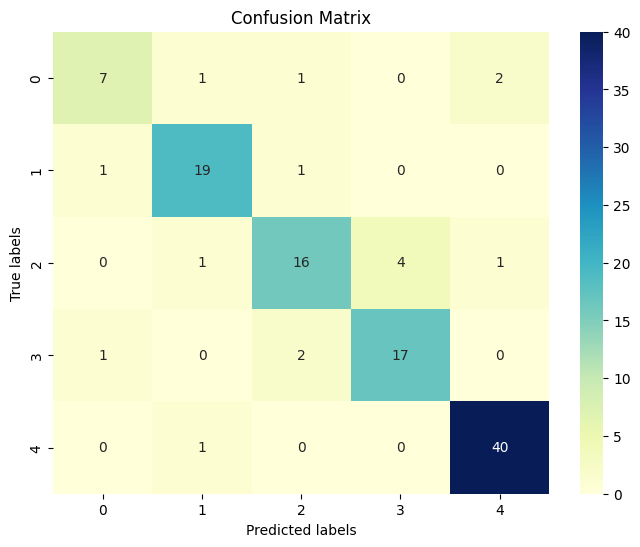

In [15]:
result_final = {
    'precision': [],
    'recall': [],
    'f1': [],
    'predictions': [],
    'targets': []
}

for k in results.keys():
    for ll in results[k]:
        for ele in ll:
            result_final[k].append(ele)
            
# print(result_final)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(result_final["targets"], result_final["predictions"])

# display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [16]:
test_loss = 0.0
classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
net.eval()

for data, target in tqdm(valid_dataloader):
    data, target = data.to(torch.float32).mean(dim=1, keepdim=True).to(device), target.argmax(dim=1).to(torch.int64).to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = net(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # print(len(target))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / (len(valid_dataloader)*4)
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 29/29 [00:04<00:00,  5.85it/s]

Test Loss: 0.0060
Test Accuracy of Age_related_Macular_Degeneration: 72% ( 8/11)
Test Accuracy of Central_serous: 71% (15/21)
Test Accuracy of Diabetic: 77% (17/22)
Test Accuracy of Macular_Hole: 70% (14/20)
Test Accuracy of Normal: 97% (40/41)
Test Accuracy of 81% (94/115)


In [17]:
# import time
# from sklearn.metrics import precision_score, recall_score, f1_score

# def test(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='mps', checkpoint_epochs=10):
#     classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())
#     class_correct = list(0 for i in range(len(classes)))
#     class_total = list(0 for i in range(len(classes)))
#     start = time.time()
#     print(f'Training for {epochs} epochs on {device}')
#     results = {
#         'precision': [],
#         'recall': [],
#         'f1': [],
#         'predictions': [],
#         'targets': []
#     }
#     if valid_dataloader is not None:
#         net.eval()  # put network in train mode for Dropout and Batch Normalization
#         valid_loss = torch.tensor(0., device=device)
#         valid_accuracy = torch.tensor(0., device=device)
#         with torch.no_grad():
#             for X, y in valid_dataloader:
#                 X = X.to(torch.float32).to(device)
#                 y = y.to(torch.float32).to(device)
#                 target = y.argmax(dim=1).to(torch.int64).to(device)
#                 preds = net(X)
#                 # print(preds.shape, y.shape)
#                 # loss = criterion(preds, y)
#                 _, pred = torch.max(preds, 1)
#                 # print(pred)
#                 # print(target)
#                 # print(y)
#                 correct_tensor = pred.eq(target.data.view_as(pred))
#                 correct = np.squeeze(correct_tensor.cpu().numpy())
#                 # print(len(target))
#                 # print(len(y))
#                 for i in range(len(y)):
#                     label = target.data[i]
#                     class_correct[label] += correct[i].item()
#                     class_total[label] += 1

            
                
                
#                 # valid_loss += loss * valid_dataloader.batch_size
#                 valid_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
                
#                 all_predictions = torch.argmax(preds, dim=1).cpu().numpy()
#                 all_targets = torch.argmax(y, dim=1).cpu().numpy()
#                 precision = precision_score(all_targets, all_predictions, average=None)
#                 recall = recall_score(all_targets, all_predictions, average=None)
#                 f1 = f1_score(all_targets, all_predictions, average=None)
                
#                 results['precision'].append(precision)
#                 results['recall'].append(recall)
#                 results['f1'].append(f1)
#                 results['predictions'].append(all_predictions)
#                 results['targets'].append(all_targets)
    
#     if valid_dataloader is not None:
#         # print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
#         print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
#     for i in range(len(classes)):
#         if class_total[i] > 0:
#             print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
#                 classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
#             ))
#         else:
#             print("Test accuracy of %5s: NA" % (classes[i]))
#     print("Test Accuracy of %2d%% (%2d/%2d)" % (
#                 100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
#             ))
    
#     end = time.time()
#     print(f'Total training time: {end-start:.1f} seconds')
#     return net, results

# net, results = test(net, train_dataloader, valid_dataloader, criterion, optimizer, None, 1, device,chk="/Users/asmitganguly/Developer/internships/UWaterloo-24/code/model/kan/weights/oct/checkpoint.pth.tar")

# # print(results)


# result_final = {
#     'precision': [],
#     'recall': [],
#     'f1': [],
#     'predictions': [],
#     'targets': []
# }

# for k in results.keys():
#     for ll in results[k]:
#         for ele in ll:
#             result_final[k].append(ele)
            
# # print(result_final)

# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# cm = confusion_matrix(result_final["targets"], result_final["predictions"])

# # display the confusion matrix as a heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
# plt.xlabel("Predicted labels")
# plt.ylabel("True labels")
# plt.title("Confusion Matrix")
# plt.show()

In [18]:
test_loss = 0.0
classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
net.eval()

for data, target in tqdm(train_dataloader):
    data, target = data.to(torch.float32).mean(dim=1, keepdim=True).to(device), target.argmax(dim=1).to(torch.int64).to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = net(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # print(len(target))
    if len(target) == 4:
        for i in range(4):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / (len(train_dataloader)*4)
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 115/115 [00:17<00:00,  6.52it/s]

Test Loss: 0.0000
Test Accuracy of Age_related_Macular_Degeneration: 100% (44/44)
Test Accuracy of Central_serous: 98% (80/81)
Test Accuracy of Diabetic: 100% (85/85)
Test Accuracy of Macular_Hole: 100% (81/81)
Test Accuracy of Normal: 100% (165/165)
Test Accuracy of 99% (455/456)


### Explainability

In [19]:
def get_2d_projection(activation_batch):
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
            reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)

In [20]:
# input_tensor, label = TrainDataset.__getitem__(0)
# input_tensor =  torch.tensor(input_tensor).to(torch.float32)
# label =  torch.tensor(label).to(torch.float32)
# input_tensor = input_tensor.unsqueeze(dim=0).mean(dim=1, keepdim=True).to(device)
# act = model_feature.get_act(input_tensor)

In [21]:
# act.shape

In [22]:
# # act = act.unsqueeze(dim=0)
# for i in range(5):
#     aa=act[:,i,:,:].cpu().detach().numpy()
#     print(aa.shape)
#     proj = get_2d_projection(aa)
#     plt.imshow((aa*proj[:,np.newaxis,:])[0])
#     plt.show()

In [23]:
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet50

# # model = resnet50(pretrained=True)
# target_layers = [net.model_feature.conv1]
# input_tensor, label = TrainDataset.__getitem__(0)
# input_tensor =  torch.tensor(input_tensor).to(torch.float32)
# label =  torch.tensor(label).to(torch.float32)
# # Note: input_tensor can be a batch tensor with several images!

# # Construct the CAM object once, and then re-use it on many images:
# # cam = GradCAM(model=net, target_layers=target_layers)
# visuals = []

# for cam in [GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad]:
#     cam = cam(model=net, target_layers=target_layers)
#     print(input_tensor.mean(dim=0).unsqueeze(dim=0).shape)
#     grayscale_cam = cam(input_tensor=input_tensor.mean(dim=0).unsqueeze(dim=0), targets=None)
#     grayscale_cam = grayscale_cam[0, :]
#     array = input_tensor.numpy()
#     array = np.transpose(array, (1, 2, 0))
#     min_val, max_val = np.min(array), np.max(array)
#     visualization = show_cam_on_image((array - min_val) / (max_val - min_val), grayscale_cam, use_rgb=False)
#     visuals.append(visualization)
    
    
# # cam = HiResCAM(model=net, target_layers=target_layers)

# # You can also use it within a with statement, to make sure it is freed,
# # In case you need to re-create it inside an outer loop:
# # with GradCAM(model=model, target_layers=target_layers) as cam:
# #   ...

# # We have to specify the target we want to generate
# # the Class Activation Maps for.
# # If targets is None, the highest scoring category
# # will be used for every image in the batch.
# # Here we use ClassifierOutputTarget, but you can define your own custom targets
# # That are, for example, combinations of categories, or specific outputs in a non standard model.

# # targets = None
# # # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# # grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(dim=0), targets=targets)

# # # In this example grayscale_cam has only one image in the batch:
# # grayscale_cam = grayscale_cam[0, :]
# # array = input_tensor.numpy()
# # array = np.transpose(array, (1, 2, 0))
# # min_val, max_val = np.min(array), np.max(array)
# # visualization = show_cam_on_image((array - min_val) / (max_val - min_val), grayscale_cam, use_rgb=False)

# # # You can also get the model outputs without having to re-inference
# # model_outputs = cam.outputs

# # from matplotlib import pyplot as plt
# # plt.imshow(visualization)
# # plt.show()

# for vis in visuals:
    
#     plt.imshow(vis)
#     plt.show()

In [24]:
# # from matplotlib import pyplot as plt
# # plt.imshow(visualization)
# # plt.show()

# for vis in visuals:
    
#     plt.imshow(vis)
#     plt.show()

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(net)

326570